# Monte Carlo Control

We alternate a single MC evaluation step and a single decaying epsilon-greedy action-selection improvement step.

We use a simple slippery walk seven environment:a single-row walk grid-world environment, with seven non-terminal states with actions effected by stochastic. This environment is noisy, but the actions the agent selects make a difference in its performance.

In [13]:
import random
import numpy as np
        
class Space:
    def __init__(self, value):
        self.n = value
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(9)
        self.action_space = Space(2)
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [14]:
env = SlipperyWalk()

The optimal state value function can be caluculated using the MDP and appliyng the Dynamic Programmaing:

In [15]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]

We need a decay schedule function for exploration (epsilon) and for evaluation (alfa)

In [7]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

A function to generate a trajectory:

In [8]:
from itertools import count

def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon) 
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

We now estimate the action-value function Q and we explore using a decaying epsilon strategy:

In [16]:
def mc_control(env, gamma=1.0,
               init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
               init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
               n_episodes=2000, max_steps=200):
    
    nS, nA = env.observation_space.n, env.action_space.n
    
    # calculate values for the discount factors in advance
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False) 
    
    # calculate alphas in advance
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    # calculare epsilons in advance
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    # setting up variables
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # define the exploratory policy based on an epsilon-greedy strategy
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    # episode loop    
    for e in range(n_episodes):
        
        # generate a trajectory using the defined exploratory policy
        trajectory = generate_trajectory(select_action, Q, epsilons[e], env, max_steps)
        
        # keep track of the visits to state-action pairs
        visited = np.zeros((nS, nA), dtype=bool)
        
        # process the trajectory
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            
            # check for state-action pair visits
            if visited[state][action]: continue
            visited[state][action] = True
            
            # calculate the return and estimate the value function (Q this time)
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])
            V = np.max(Q, axis=1)

        # save values for post analysis
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    
    # At the end, we extract the state-value function and the greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

Let’s use the algorithms to optimize an agent for the Slippery Walk Seven environment:

This first one is first-visit Monte Carlo control (on-policy, no bootstrapping)

In [18]:
Q_mc, V_mc, pi_mc, Q_track_mc, V_track_mc, pi_track_mc = mc_control(env)

In [19]:
print(V_mc)

[0.         0.60107938 0.81516407 0.91389773 0.96457221 0.9789717
 0.99735081 0.99999995 0.        ]


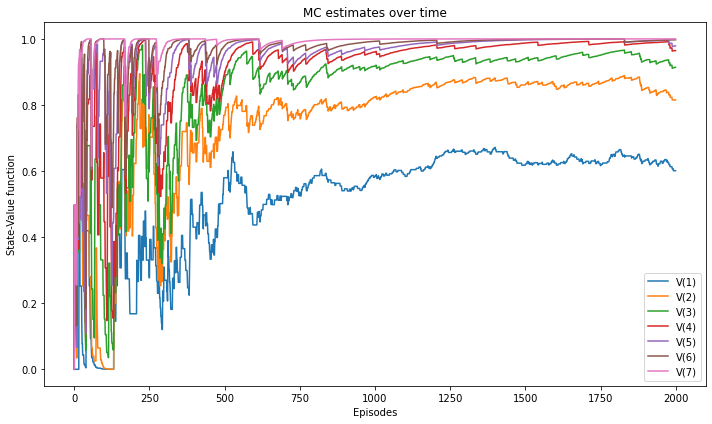

In [20]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))
plt.plot(V_track_mc[:,1:8])
plt.title('MC estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()